In [1]:
# sys, file and nav packages:
import datetime as dt
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 100

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'dist_map'

# get your data:
df= pd.read_csv('checked_sdata_eos_2020_21.csv')

with open("river_basins.json", "r") as infile:
    river_bassins = json.load(infile)

dfBeaches = pd.read_csv("beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("codes_with_group_names_2015.csv")
dfDims = pd.read_csv("corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)
        
dfCodes.set_index("code", inplace=True)

# Changes in Spearmans $\rho$ as buffer size changes

Spearmans ranked test for correlation is being used to test the association of the number of objects found on the beach with the type of land use within a defined radius of the location where the objects were found.

The national survey on land use is the source for the classification of land use types. For every 100m² of the national territory there is an attributed land use classification based on the analysis of aerial images.

In [2]:
# this is the aggregated survey data that is being used
fd = df.copy()
fd['loc_dates'] = list(zip(fd.location.values, fd.date.values))
fd['date'] = pd.to_datetime(fd.date)

# the location data for the surveys
dfb = dfBeaches.loc[fd.location.unique()].copy()

In [3]:
# the landuse descriptors are integers, key them to a readable descriptor
# no27 is the results of intersecting buffer to Land use
label_keys = {
    1:"industrial",
    2:"residential",
    3:"government",
    4:"agg_buildings",
    5:"unk_building",
    6:"roads",
    7:"railways",
    8:"airports",
    9:"special",
    10:"recreational",
    11:"orchards",
    12:"vineyards",
    13:"horticulture",
    14:"arable",
    15:"meadows",
    16:"farmpastures",
    17:"alpinemeadows",
    18:"aplinepasteurs",
    19:"closed_forest",
    20:"open_forest",
    21:"brush_forest",
    22:"woods",
    23:"lakes",
    24:"rivers",
    25:"unproductive",
    26:"bareland",
    27:"glaciers"
}

# group the land use into functional groups
group_parts = {'buildings':[2,3,4,5,9],
               'ind':[1],              
               'trans':[6,7,8],
               'recreation':[10],
               'agg':[11, 12, 13, 14, 15, 16, 18],
               'woods':[17,19,20,21,22],
               'water':[23,24],
               'unproductive':[25,26,27]
              }

# make column names based on the key values:
as_1827_part ={k:F"part_{v}" for k,v in label_keys.items()}

# map survey results to these aggregated luse features
som_cols = ['% to buildings',
            '% to ind',
            '% to trans',
            '% to recreation',
            '% to agg',
            '% to woods',
            '% to water',
            '% to unproductive',
                
]

# define functions to map luse data to survey locations
def aggregate_buffer_data(data, cols, bufferdata, label_keys, **kwargs):
    
    # make empty columns for the measured land use features
    for acol in cols:
        data[acol]= 0

    # assign values to each column
    for beach in data.index:
        for label in list(label_keys.values()):        
            try:
                new_data = bufferdata[(bufferdata.slug == beach)&(bufferdata.label == label)].AS18_27.values[0]
            except:
                new_data = 0
            data.loc[beach, label] = new_data
    return data

# account for the area attributed to water by removing the
# the value of water features from land use total
def adjusted_land_use(data, col_keys):
    # total land use
    data['luse_total'] = data.loc[:,list(col_keys.values())].sum(axis=1)

    # amount attributed to water
    data['water_value'] = data.loc[:, ['lakes','rivers']].sum(axis=1)

    # the adjsuted land use
    # remove the water value from land use stats
    data['adjusted_land_use'] = data.luse_total - data.water_value
    
    return data

# determine the ration of each landuse feature to the adjusted total for each buffer
def account_for_adj_luse(data, col_keys):
    for label in list(col_keys.values()):
        a_label = F"part_{label}"
        data[a_label] = data[label]/data['adjusted_land_use']
    return data

# aggregate the groups
def aggregate_the_luse_groups(data, groups, group_parts, as_1827_part):
    for a_group in group_parts.keys():
        part_groups = [as_1827_part[x] for x in group_parts[a_group]]
        new_group = F"% to {a_group}"
        data[new_group] = data.loc[:,part_groups].sum(axis=1)
    
    return data

# merge survey results to land use stats
def assign_luse_stat_to_survey_results(sdata, luse_data, som_cols):
    for a_beach in sdata.location.unique():
        for element in som_cols:
            sdata.loc[sdata.location == a_beach, element] = luse_data.loc[a_beach, element]
    return sdata

# apply method and check results
def check_hypothesis(this_data, some_codes, variables, method):
    myresults = {}
    for i,code in enumerate(some_codes):
        data = this_data[this_data.code == code]
        code_results ={code:{}}
        for j, n in enumerate(variables):
            corr, a_p = method(data[n], data[unit_label])
            if a_p <= 0.05:
                code_results[code].update({n:corr})
        myresults.update(code_results)
    
    return myresults

### 1500 meters codes with an association to a landuse feature

Where p <= 0.05 for Spearmans test for association.

In [4]:
# no27 = pd.read_csv("noas04_27.csv")

# # the buffer results from qgis
# lu_1500 = no27[["AS18_27", "slug"]].copy()
# lu_1500.rename(columns={'location':'slug'}, inplace=True)

# # make a df with location slug, landuse label and land use value:
# for a_num in lu_1500.AS18_27.unique():
#     lu_1500.loc[lu_1500.AS18_27==a_num, "label"]=label_keys[a_num]

# # the locations that need land use data
# data = pd.DataFrame(index = fd.location.unique())

# # records with a quantity greater than 30
# abundant_codes = fd[fd.quantity > 20].code.unique()

# # getting a list of the current landuse categories
# add_these_cols = lu_1500.label.unique()

# # counting the number of points inside the buffer for each category and location
# bufferdata = lu_1500.groupby(['slug','label'], as_index=False).AS18_27.count()

# these_groups = list(group_parts.keys())

# some_data = aggregate_buffer_data(data, add_these_cols, bufferdata, label_keys)

# sd_0 = adjusted_land_use(some_data, label_keys)

# sd_1 = account_for_adj_luse(data, label_keys)

# sd_1500 = aggregate_the_luse_groups(data, add_these_cols, group_parts, as_1827_part)
# sd_1500['dist'] = 1500


# fd_luse = assign_luse_stat_to_survey_results(fd, sd_1500,som_cols)    

# this_data = fd_luse[[unit_label,*som_cols, 'code']]

# myresults = check_hypothesis(this_data, abundant_codes, som_cols, stats.spearmanr)

# srho_results_1500 = pd.DataFrame.from_dict(myresults, orient='index')
# srho_results_1500.fillna("X", inplace=True)
# srho_results_1500['dist'] = 1500

# # the survey data with land use attached

In [5]:
fd.columns

Index(['date', 'code', 'pcs_m', 'quantity', 'location', 'loc_date',
       'water_name_slug', 'river_bassin', 'length', 'ilength', 'groupname',
       'city', 'population', 'intersects', 'fail', '% to buildings',
       '% to trans', '% to recreation', '% to agg', '% to woods', '% to water',
       '% to unproductive', 'streets', 'month', 'eom', 'material', 'w_t',
       'streets km', 'p/100m', 'area', 'loc_dates'],
      dtype='object')

## The cookie problem revisited, using trash data

reference: [ThinkBayes2](http://allendowney.github.io/ThinkBayes2/chap03.html)

There are 4 survey areas. Imagine the collected objects were put into four separate piles (all 54,000 objects). One four each survey area.

Without looking at the pile, you choose one object at random from one of the piles.

* What is the chance that you will pull one Gfrags from any of the piles?

* Suppose you pull out one G112, what is the chance of that happening? Which survey area do you suppose it came from (what pile do you suppose it came from)

The question is asking to choose from a pile of existing objects. Survey values equal to zero can be excluded

The probability of pulling a Gfrags from a pile would be equal to the sum of the probabilities of finding a Gfrags in each pile

In [6]:
# remove zero values
data = fd[fd.quantity>0].copy()

qtot = data.groupby('river_bassin').quantity.sum()
qgfrag = data[data.code == "Gfrags"].groupby(['river_bassin']).quantity.sum()

In [7]:
# the ratio of Gfrags to all other objects:
rgfrag = qgfrag.sum()/qtot.sum()
rgfrag

0.13517463100979102

In [8]:
# the chance that one of the survey areas will be selected
# the prior probability
prbasin = pd.Series([.25]*4, index=[qtot.index])
prbasin

river_bassin
aare            0.25
linth           0.25
rhone           0.25
ticino          0.25
dtype: float64

In [9]:
# the ration of Gfrags in each survey area
# update the the probability with new data
# the probability of Gfrag given a survey area P(Gfrag|Survey area)
pgfrag = qgfrag/qtot
pgfrag

river_bassin
aare      0.144724
linth     0.097429
rhone     0.148310
ticino    0.085450
Name: quantity, dtype: float64

In [10]:
# unormalized posteriors
pgfragbasin = prbasin.to_numpy() * pgfrag.to_numpy()
pgfragbasin

array([0.03618112, 0.0243572 , 0.03707739, 0.02136259])

In [11]:
# normalize the probabilities
new_probs = [(x)/sum(pgfragbasin) for x in pgfragbasin]

# the probability that Gfrags came from one survey area or the other
new_probs

[0.3040984962070841,
 0.20471971331403258,
 0.31163151522311155,
 0.1795502752557717]

There is a 13% chance of pulling a Grags from the collection of objects. But the Gfrags most likely came from the Rhône or Aare survey areas.

## Credible intervals

The sample problem from [ThinkBayes2 Chap 5](http://allendowney.github.io/ThinkBayes2/chap05.html#credible-intervals)


Any object has some probability of being found at any survey. It is reasonable to assume that the probability of an object being found at any location depends on the features of the location and the object. It is also reasonable to assume that locations that have common features would have results that are similar for the same object categories.

### Mean of the posterior distribution

Example from the book

In [12]:
hypos = np.arange(1, 1001)
prior = pd.Series(data=[1]*len(hypos), index=hypos)
limit = 60
def update_train(pmf, limit):
    """Update pmf based on new data."""
    hypos = pmf.index.values
    likelihood = 1 / hypos
    impossible = (limit > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf /= pmf.sum() # normalize

posterior = prior.copy()
update_train(posterior, limit)

<AxesSubplot:>

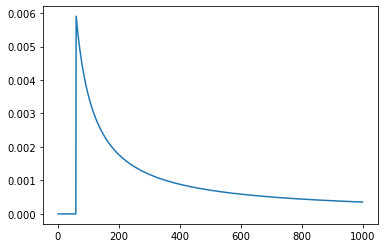

In [13]:
sns.lineplot(x=posterior.index, y=posterior)

In [14]:
# the mean of the posterior distribution
(posterior*posterior.index.values).sum()

333.41989326370776

In [15]:
data.head()

,date,code,pcs_m,quantity,location,loc_date,water_name_slug,river_bassin,length,ilength,...,% to unproductive,streets,month,eom,material,w_t,streets km,p/100m,area,loc_dates
0,2021-05-01,G191,0.01,1,maladaire,"('maladaire', '2021-05-01')",lac-leman,rhone,77.0,77.714286,...,0.0,75317,5,2021-05-31,Metal,l,75.317,1.0,0,"(maladaire, 2021-05-01)"
1,2021-05-01,G35,0.01,1,maladaire,"('maladaire', '2021-05-01')",lac-leman,rhone,77.0,77.714286,...,0.0,75317,5,2021-05-31,Plastic,l,75.317,1.0,0,"(maladaire, 2021-05-01)"
2,2021-05-01,G21,0.01,1,maladaire,"('maladaire', '2021-05-01')",lac-leman,rhone,77.0,77.714286,...,0.0,75317,5,2021-05-31,Plastic,l,75.317,1.0,0,"(maladaire, 2021-05-01)"
3,2021-05-01,G67,0.03,2,maladaire,"('maladaire', '2021-05-01')",lac-leman,rhone,77.0,77.714286,...,0.0,75317,5,2021-05-31,Plastic,l,75.317,3.0,0,"(maladaire, 2021-05-01)"
4,2021-05-01,G23,0.01,1,maladaire,"('maladaire', '2021-05-01')",lac-leman,rhone,77.0,77.714286,...,0.0,75317,5,2021-05-31,Plastic,l,75.317,1.0,0,"(maladaire, 2021-05-01)"


In [65]:
from scipy.stats import binom


4.8021295248501773e-08

__using trash data__

In [118]:
# conditions
city = 'Yverdon-les-Bains'
objct = "G112"
lake = "neuenburgersee"

def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return ks, ps



data = fd[fd.water_name_slug == lake].copy()

# assume the chance of finding one of the objects at a survey
# was the same at all locations on the lake. That can be 
# approximated by taking the ratio of samples > 0 for that object
plake = fd[(fd.water_name_slug == lake)&(fd.code == objct)].quantity > 0

hypos = np.arange(1, 45)
p = plake.mean()

# the distribution of object survey results assuming uniform probability at all locations
x, y = make_binomial(45, p)
prior = pd.Series(data=y, index=x)

# the likelihood at each sample can be calculated
dfdt = fd[fd.water_name_slug == lake].groupby('loc_date', as_index=False).quantity.sum()
dfdt['objct'] = dfdt.loc_date.map(lambda x: fd[(fd.code == objct)&(fd.loc_date == x)].quantity.to_numpy()[0])
dfdt['likelihood'] = dfdt.objct/dfdt.quantity
dfdt['likelihood'] = dfdt.likelihood.where(dfdt.likelihood > 0, p)
posterior = prior.copy()
posterior *= dfdt.likelihood
posterior  /= posterior.sum()

<AxesSubplot:>

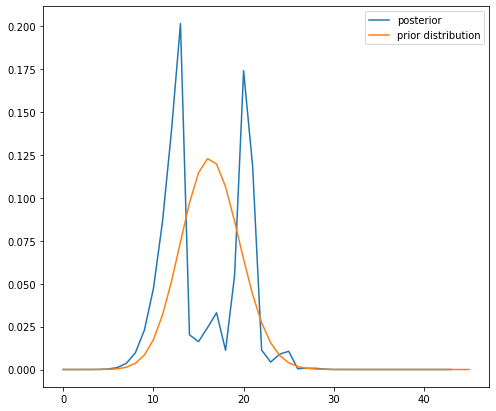

In [119]:
fig, ax = plt.subplots(figsize=(8,7))

sns.lineplot(x=posterior.index, y=posterior, ax=ax, label='posterior')
sns.lineplot(x=x, y=y, ax=ax, label='prior distribution')

In [120]:
# the mean of the posterior distribution
(posterior*posterior.index.values).sum()

15.582538145644593

In [123]:
posterior[posterior == posterior.max()]

13    0.201319
dtype: float64

In [121]:
(x*y).sum()

16.363636363636893

In [130]:
p

0.36363636363636365

In [145]:
# The probability of finding one objct on the lake is the sum of the probability of finding
# that object at all the different locations.

# the locations on the lake
locs = data.city.unique()
bycity = data.groupby(['city']).loc_date.nunique()
gzero = data[(data.code == objct)&(data.quantity > 0)].groupby("city").loc_date.nunique()

In [155]:
bycity

city
Boudry                1
Cheyres-Châbles      13
Cudrefin              1
Estavayer             1
Grandson              1
Hauterive (NE)        1
Neuchâtel            13
Yverdon-les-Bains    13
Name: loc_date, dtype: int64

In [164]:
cityweight = bycity/data.loc_date.nunique()
cityweight

city
Boudry               0.022727
Cheyres-Châbles      0.295455
Cudrefin             0.022727
Estavayer            0.022727
Grandson             0.022727
Hauterive (NE)       0.022727
Neuchâtel            0.295455
Yverdon-les-Bains    0.295455
Name: loc_date, dtype: float64

In [157]:
gzero

city
Cheyres-Châbles       4
Estavayer             1
Grandson              1
Yverdon-les-Bains    10
Name: loc_date, dtype: int64

In [170]:
probs = (gzero/bycity).fillna(p)
newp = probs*cityweight
newp = newp/newp.sum()

In [173]:
probs

city
Boudry               0.363636
Cheyres-Châbles      0.307692
Cudrefin             0.363636
Estavayer            1.000000
Grandson             1.000000
Hauterive (NE)       0.363636
Neuchâtel            0.363636
Yverdon-les-Bains    0.769231
Name: loc_date, dtype: float64

In [172]:
newp

city
Boudry               0.016667
Cheyres-Châbles      0.183333
Cudrefin             0.016667
Estavayer            0.045833
Grandson             0.045833
Hauterive (NE)       0.016667
Neuchâtel            0.216667
Yverdon-les-Bains    0.458333
Name: loc_date, dtype: float64

In [171]:
data[data.cit]

1.0

In [169]:
probs.sum()

4.531468531468532

In [116]:
total = 0
for q,p in posterior.items():    
    total += p
    print(total)
    if total >= .5:
        ptile = q
        break

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.10877479592233553
0.19617491826379038
0.32769129283474274
0.5057480091072712


In [117]:
ptile

17

In [115]:
posterior.sum()

1.0

In [94]:
posterior

0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     0.000000e+00
6     0.000000e+00
7     0.000000e+00
8     0.000000e+00
9     0.000000e+00
10    0.000000e+00
11    0.000000e+00
12    0.000000e+00
13    0.000000e+00
14    1.087748e-01
15    8.740012e-02
16    1.315164e-01
17    1.780567e-01
18    6.018819e-02
19    2.953275e-01
20    0.000000e+00
21    0.000000e+00
22    6.073062e-02
23    2.335169e-02
24    4.811790e-02
25    0.000000e+00
26    2.465570e-03
27    4.003917e-03
28    0.000000e+00
29    0.000000e+00
30    6.506646e-05
31    0.000000e+00
32    1.564411e-06
33    0.000000e+00
34    0.000000e+00
35    9.026877e-09
36    0.000000e+00
37    0.000000e+00
38    0.000000e+00
39    9.859657e-13
40    0.000000e+00
41    0.000000e+00
42    0.000000e+00
43    4.579595e-17
44             NaN
45             NaN
dtype: float64

In [ ]:
likelihood

In [ ]:
prior*likelihood/len(prior)

In [ ]:
KS

In [ ]:
sns.lineplot(x=x, y=y)

In [ ]:
pheads = pd.DataFrame(data=y, index=x, columns=['prob'])
pheads.loc[pheads.index >= 140].sum()

In [ ]:
pheads.loc[pheads.index <= 110].sum()

### Binomial distribution trash data

In [ ]:
# conditions
city = 'Yverdon-les-Bains'
objct = "G112"
lake = "neuenburgersee"

data = fd[fd.water_name_slug == lake]

nsee = fd[(fd.code == objct)&(fd.water_name_slug == lake)&(fd.city != city)].copy()
cty = fd[(fd.code == objct)&(fd.water_name_slug == lake)&(fd.city == city)].copy()

# assume the chance of finding one of the objects at a survey
# was the same at all locations on the lake. That can be 
# approximated by taking the ratio of samples > 0 for that object
plake = fd[(fd.water_name_slug == lake)&(fd.code == objct)].quantity > 0

# the ratio samples that have at least one of the objects
plake.mean()

In [ ]:
# the number of samples on the lake with at least one objct
plake.sum()

In [ ]:
# boolean series
ctyx = (cty.code == objct)&(cty.water_name_slug == lake)&(cty.city == city)
cnzero = cty.quantity > 0

nseex = (nsee.code == objct)&(nsee.water_name_slug == lake)&(nsee.city != city)
nseenzero = nsee.quantity > 0

# the ratio of samples with the objct at ylb
cnzero.mean()

In [ ]:
# the number of samples with at least one objct at ylb
cnzero.sum()

In [ ]:
n = data.loc_date.nunique()
p = plake.mean()
tsamps = [1]*n

xobjct, yobjct = make_binomial(n, p)

prior = pd.DataFrame(data=yobjct, index=xobjct, columns=['prob'])

# the ratio of 10/13 = x/44
tmax = ((10*44)/13)

In [ ]:
fig, ax = plt.subplots(figsize=(8,7))
sns.lineplot(data=prior, x=prior.index, y='prob', ax=ax)
ax.scatter(tmax, prior.loc[prior.index >= tmax].sum(), c='red')

In [ ]:
# the probability that 10/13 or 34/44 samples will have at least one objct
# given the assumption that all locations have the same probability
prior.loc[prior.index > tmax].sum()

In [ ]:
# the most probable value is 16 at .12
prior[prior.prob == prior.prob.max()]

In [ ]:
break

In [ ]:
# the probability of finding at least k amount of an object o:
unit_label = 'p/100m'
nsamps = pg112city.loc_date.nunique()
nobjects = pg112city[unit_label].max()
anindex = np.arange(start=0, stop=nobjects+1, step=1)

data = pg112city.copy()

p_object = pd.DataFrame(index=anindex)

for obj in anindex:
    n = len(pg112city[unit_label] > obj)
    p = n/nsamps
    p_object.loc[obj, objct] = p

In [ ]:
fig, ax = plt.subplots()
p_object["1-p"] = 1-p_object[objct] 
sns.scatterplot(data=p_object, x=p_object.index, y=p_object[objct], label=f"p of {objct}", color='red', ax=ax)
sns.scatterplot(data=p_object, x=p_object.index, y=p_object["1-p"], label=f"1-p", ax=ax)
plt.show()

In [ ]:
p_object

In [ ]:
fd[fd.code == objct][unit_label].median()

In [ ]:
p_object[objct].sum()

In [ ]:
pbaare = pd.DataFrame(index=anindex)

In [ ]:
pbaare[objct] = 0

for obj in anindex:
#     print(obj)
    n = len(fd[(fd.code == objct) & (fd.quantity > obj)&(fd.river_bassin == rb)])
    p = n/nsamps
#     print(n)
#     print(n/fd[fd.river_bassin == rb].loc_date.nunique())
    pbaare.loc[obj, objct] = p

In [ ]:
fig, ax = plt.subplots()
pbaare["1-p"] = 1-pbaare[objct] 
sns.scatterplot(data=p_object, x=p_object.index, y=p_object[objct], label=f"p of {objct}", color='red', ax=ax)
sns.scatterplot(data=pbaare, x=pbaare.index, y=pbaare[objct], label=f"P({objct}|{rb})", color='blue', ax=ax)
# sns.lineplot(data=p_object, x=p_object.index, y=p_object["1-p"], label=f"1-p", ax=ax)
plt.show()

In [ ]:
pdist.x[:30]